# Train a Machine Translation model FR->EN with BLEU Score
### *Use a list a translated sentences in French and English to train the model*
### \#Keras \#Deep Learning \#NLTK \#BLEU Score




![translation](https://i.imgur.com/oRErxJM.png)

# Table of contents

[<h3>1. Data Preprocessing</h3>](#1)

[<h3>2. Create and train the model</h3>](#2)

[<h3>3. Result on the test set</h3>](#3)

[<h3>4. Prediction evaluation with BLEU</h3>](#4)

## 1. Data Preprocessing<a class="anchor" id="1"></a><a class="anchor" id="1"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import string
import re
from unicodedata import normalize
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [3]:
# How many sentences will be used
# Limit the sentences to 10.000 on Kaggle to avoid exceding the
# available RAM space
# Build a generator to avoid this issue

total_sentences = 10000

# Load the dataset
dataset = pd.read_csv("eng_-french.csv", nrows = total_sentences)

# What proportion of the sentences will be used for the test set
test_proportion = 0.1
train_test_threshold = int( (1-test_proportion) * total_sentences)

printmd(f'## {total_sentences} "parallel sentences" will be loaded (original sentence + its translation)')
printmd(f'## {train_test_threshold} "parallel sentences" will be used to train the model')
printmd(f'## {total_sentences-train_test_threshold} "parallel sentences" will be used to test the model')

## 10000 "parallel sentences" will be loaded (original sentence + its translation)

## 9000 "parallel sentences" will be used to train the model

## 1000 "parallel sentences" will be used to test the model

In [4]:
# Shuffle the dataset
dataset = dataset.sample(frac=1, random_state=0)
dataset.iloc[1000:1010]

,English words/sentences,French words/sentences
1554,Let me die.,Laisse-moi mourir.
2087,He's a slob.,C'est un flemmard.
5470,I have to try.,Il faut que j'essaie.
2363,I was naive.,Je fus crédule.
7570,He is bankrupt.,Il est en faillite.
6427,That's a fact.,C'est un fait.
1651,Talk to me!,Parlez-moi !
4164,Keep talking.,Continuez de parler.
1231,I broke it.,Je l'ai cassée.
9232,Tom is a judge.,Tom est juge.


In [5]:
def clean(string):
    # Clean the string
    string = string.replace("\u202f"," ") # Replace no-break space with space
    string = string.lower()
    
    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "0123456789":
        string = string.replace(p," ")
        
    string = re.sub('\s+',' ', string)
    string = string.strip()
           
    return string

# Clean the sentences
dataset["English words/sentences"] = dataset["English words/sentences"].apply(lambda x: clean(x))
dataset["French words/sentences"] = dataset["French words/sentences"].apply(lambda x: clean(x))

# Select one part of the dataset
dataset = dataset.values
dataset = dataset[:total_sentences]

# split into train/test
train, test = dataset[:train_test_threshold], dataset[train_test_threshold:]

# Define the name of the source and of the target
# This will be used in the outputs of this notebook
source_str, target_str = "French", "English"

# The index in the numpy array of the source and of the target
idx_src, idx_tar = 1, 0

In [6]:
# Display the result after cleaning
pd.DataFrame(dataset[1000:1010])

,0,1
0,let me die,laisse moi mourir
1,he s a slob,c est un flemmard
2,i have to try,il faut que j essaie
3,i was naive,je fus crédule
4,he is bankrupt,il est en faillite
5,that s a fact,c est un fait
6,talk to me,parlez moi
7,keep talking,continuez de parler
8,i broke it,je l ai cassée
9,tom is a judge,tom est juge


In [7]:
def create_tokenizer(lines):
    # fit a tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
def max_len(lines):
    # max sentence length
    return max(len(line.split()) for line in lines)
    # retourne 12 pour francais 
    # retourne 5 pour anglais

def encode_sequences(tokenizer, length, lines):
    # encode and pad sequences
    X = tokenizer.texts_to_sequences(lines) # integer encode sequences
    X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
    return X
 
def encode_output(sequences, vocab_size):
    # one hot encode target sequence
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# Prepare target tokenizer
tar_tokenizer = create_tokenizer(dataset[:, idx_tar])
tar_vocab_size = len(tar_tokenizer.word_index) + 1
tar_length = max_len(dataset[:, idx_tar])
printmd(f'\nTarget ({target_str}) Vocabulary Size: {tar_vocab_size}')
printmd(f'Target ({target_str}) Max Length: {tar_length}')

# Prepare source tokenizer
src_tokenizer = create_tokenizer(dataset[:, idx_src])
src_vocab_size = len(src_tokenizer.word_index) + 1
src_length = max_len(dataset[:, idx_src])
printmd(f'\nSource ({source_str}) Vocabulary Size: {src_vocab_size}')
printmd(f'Source ({source_str}) Max Length: {src_length}\n')
 
# Prepare training data
trainX = encode_sequences(src_tokenizer, src_length, train[:, idx_src])
trainY = encode_sequences(tar_tokenizer, tar_length, train[:, idx_tar])
trainY = encode_output(trainY, tar_vocab_size)

# Prepare test data
testX = encode_sequences(src_tokenizer, src_length, test[:, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[:, idx_tar])
testY = encode_output(testY, tar_vocab_size)


Target (English) Vocabulary Size: 2099

Target (English) Max Length: 5


Source (French) Vocabulary Size: 4039

Source (French) Max Length: 12


In [8]:
trainX.shape

(9000, 12)

In [9]:
trainY.shape

(9000, 5, 2099)

In [10]:
src_length

12

In [11]:
trainX[0]

array([  6,  13, 465, 376,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [12]:
trainY[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
tar_length

5

# 2. Create and train the model<a class="anchor" id="2"></a>

In [14]:
src_vocab_size

4039

In [15]:
def create_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    # Create the model
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model
 
# Create model
model = create_model(src_vocab_size, tar_vocab_size, src_length, tar_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 12, 256)           1033984   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 2099)           539443    
Total params: 2,624,051
Trainable params: 2,624,051
Non-trainable params: 0
_________________________________________________________________


In [17]:

history = model.fit(trainX, 
          trainY, 
          epochs=200, 
          batch_size=64, 
          validation_split=0.1, 
          verbose=1,
          callbacks=[
                        EarlyStopping(
                        monitor='val_loss',
                        patience=10,
                        restore_best_weights=True
                    )
            ])

Epoch 1/200
127/127 [==============================] - 30s 197ms/step - loss: 5.4271 - val_loss: 3.5188
Epoch 2/200
127/127 [==============================] - 23s 182ms/step - loss: 3.3700 - val_loss: 3.3018
Epoch 3/200
127/127 [==============================] - 24s 188ms/step - loss: 3.1315 - val_loss: 3.1321
Epoch 4/200
127/127 [==============================] - 25s 194ms/step - loss: 2.9344 - val_loss: 3.0170
Epoch 5/200
127/127 [==============================] - 24s 191ms/step - loss: 2.7931 - val_loss: 2.9262
Epoch 6/200
127/127 [==============================] - 24s 190ms/step - loss: 2.6549 - val_loss: 2.8333
Epoch 7/200
127/127 [==============================] - 24s 192ms/step - loss: 2.5268 - val_loss: 2.7317
Epoch 8/200
127/127 [==============================] - 24s 192ms/step - loss: 2.3835 - val_loss: 2.6293
Epoch 9/200
127/127 [==============================] - 24s 191ms/step - loss: 2.2495 - val_loss: 2.5272
Epoch 10/200
127/127 [==============================] - 24s 192m

In [ ]:
from tensorflow.keras.models import load_model

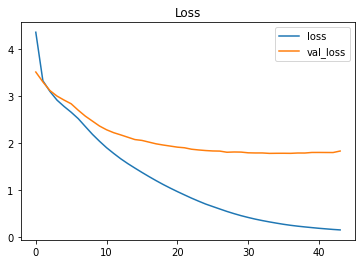

In [ ]:
pd.DataFrame(history.history).plot()
plt.title("Loss")
plt.show()

# 3. Result on the test set<a class="anchor" id="3"></a>

In [22]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    #prediction = model.predict(source, verbose=0)
    prediction = model.predict(source, verbose=0)[0]

    #print('prediction.shape :',prediction.shape)
    print('prediction_0.shape :',prediction.shape)

    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        print('source shape :', source.shape)
        translation = predict_seq(model, tar_tokenizer, source)
        print('source shape : ',source.shape)
        raw_target, raw_src = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: # Display some of the result
            break
 
# test on some training sequences
print('### Result on the Training Set ###')
compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_prediction(model, tar_tokenizer, testX, test)

### Result on the Training Set ###
FRENCH (SOURCE)                ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH

source shape : (1, 12)
prediction_0.shape : (5, 2099)
source shape :  (1, 12)
nous en savons assez           we know enough            we know enough
source shape : (1, 12)
prediction_0.shape : (5, 2099)
source shape :  (1, 12)
garde ton sang froid           stay calm                 stay calm
source shape : (1, 12)
prediction_0.shape : (5, 2099)
source shape :  (1, 12)
je ne pleurerai pas            i won t cry               i won t cry
source shape : (1, 12)
prediction_0.shape : (5, 2099)
source shape :  (1, 12)
je ne suis pas contente        i m not happy             i m not happy
source shape : (1, 12)
prediction_0.shape : (5, 2099)
source shape :  (1, 12)
moi je veux ça                 i want that               i want that
source shape : (1, 12)
prediction_0.shape : (5, 2099)
source shape :  (1, 12)
j étais tellement heureuse     i was so happy            i

# 4. Prediction evaluation with BLEU <a class="anchor" id="4"></a>

BLEU (bilingual evaluation understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation, the better it is" – this is the central idea behind BLEU. BLEU was one of the first metrics to claim a high correlation with human judgements of quality, and remains one of the most popular automated and inexpensive metrics.

Scores are calculated for individual translated segments—generally sentences—by comparing them with a set of good quality reference translations. Those scores are then averaged over the whole corpus to reach an estimate of the translation's overall quality. Intelligibility or grammatical correctness are not taken into account.

BLEU's output is always a number between 0 and 1. This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts. Few human translations will attain a score of 1, since this would indicate that the candidate is identical to one of the reference translations. For this reason, it is not necessary to attain a score of 1. Because there are more opportunities to match, adding additional reference translations will increase the BLEU score.


## Algorithm

BLEU uses a modified form of precision to compare a candidate translation against multiple reference translations. The metric modifies simple precision since machine translation systems have been known to generate more words than are in a reference text. This is illustrated in the following example from Papineni et al. (2002)

![example bleu](https://i.imgur.com/mrdpwun.png)

Of the seven words in the candidate translation, all of them appear in the reference translations. Thus the candidate text is given a unigram precision of P, where *m* is number of words from the candidate that are found in the reference, and *wt* is the total number of words in the candidate. This is a perfect score, despite the fact that the candidate translation above retains little of the content of either of the references.

The modification that BLEU makes is fairly straightforward. For each word in the candidate translation, the algorithm takes its maximum total count, *m_max*, in any of the reference translations. In the example above, the word "the" appears twice in reference 1, and once in reference 2. Thus *m_max* = 2.

For the candidate translation, the count *mw* of each word is clipped to a maximum of *m_max* for that word. In this case, "the" has *m_w* = 7 and *m_max*=2, thus *m_w* is clipped to 2. These clipped counts *m_w* are then summed over all distinct words in the candidate. This sum is then divided by the total number of unigrams in the candidate translation. In the above example, the modified unigram precision score would be: P = 1 / 7

In practice, however, using individual words as the unit of comparison is not optimal. Instead, BLEU computes the same modified precision metric using n-grams. The length which has the "highest correlation with monolingual human judgements" was found to be four. The unigram scores are found to account for the adequacy of the translation, how much information is retained. The longer n-gram scores account for the fluency of the translation, or to what extent it reads like "good English". ([source](https://en.wikipedia.org/wiki/BLEU))

![bleu score 2](https://i.imgur.com/tNYaD64.png)

In [ ]:
# It takes long to compute the BLEU Score

def bleu_score(model, tokenizer, sources, raw_dataset):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())
        
    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

# Compute the BLEU Score
bleu_train = bleu_score(model, tar_tokenizer, trainX, train)
bleu_test = bleu_score(model, tar_tokenizer, testX, test)

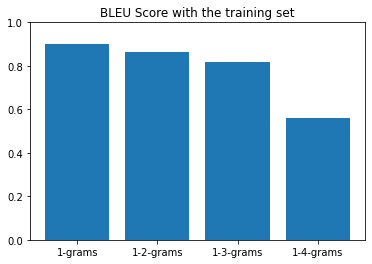

In [ ]:
plt.bar(x = bleu_train.keys(), height = bleu_train.values())
plt.title("BLEU Score with the training set")
plt.ylim((0,1))
plt.show()

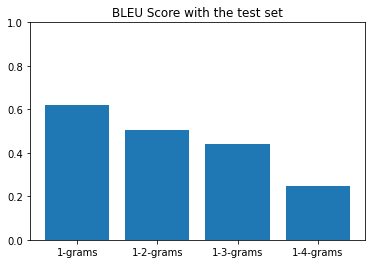

In [ ]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.show()